# **Proof of Inefficient ADP Through Player Archetype Clustering**
## Participants: Skunkwork Analytics (Travis Rothlisberger)

**twitter**: [@tburger101](https://twitter.com/tburger101)


**Summary:** This notebook explores how different player archetypes can outperform ADP, improve playoff advance rates, and increase your odds at a top 1% team. To analyze this, we group players in 1 of 3 clusters: Not Explosive, Neutral, and Explosive. Inspired by card counting strategy the Not Explosive bucket will be assigned a value of -1, Neutral 0, and Explosive +1.

Additional implementation details can be found in the methodology section.

*Note*: To obtain extra processing power for the analysis I used a Google Colab notebook. I took the data folder, put it into my G Drive, and mounted my G Drive to access the data

In [1]:
%pip install nfl_data_py
import nfl_data_py as nfl
import pandas as pd
import json
import os
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.9 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.0-py3-none-any.whl size=25086 sha256=6a15531bce6e22f6e881b18d2bd236239ccb70db0186e5d5ff67bba85aa9f859
  Stored in directory: /root/.cache/pip/wheels/83/17/5a/750f2a5cec7b32c7df0a0130ae6abb97ffb44dee391c6d8d27
Successfully built nfl_data_py


# **Methodology**

**Steps**
1.   First we pull in play-by-play data for 2020 and 2021 as we will use play level data for our player clustering.
2.   We will create three cluster types: REC, PASS, and RUSH. Each cluster type will contain three buckets: Not Explosive, Neutral, and Explosive. To determine which bucket a player falls into we will compare the average and standard deviation of play-by-play results against his positional group. For example, for WRs we will take the average and standard deviation of all receptions to determine a REC cluster
3.   Inspired by card counting strategy the Not Explosive bucket will be assigned a value of -1, Neutral 0, and Explosive +1. Any players with less than 20 receptions, passes, or rushes from the prior year will be excluded and put in the Neutral cluster.
4.   TE/WRs will only have a REC cluster type. RBs will have both a REC and RUSH cluster type. QBs will have RUSH and PASS cluster types.
5.   RBs cannot fall into the Not Explosive REC cluster and QBs cannot fall into the Not Explosive RUSH cluster. It didn't feel right to penalize these two positions for statistical categories which aren't their primary focus.
5.   Next each player will be assigned a total_cluster_value which is calculated as RUSH cluster value + PASS cluster value + REC cluster value. Note: Dual threat RBS and QBs have the ability to fit into two Explosive cluster buckets.
6.   Finally, we use these cluster values to see their effects on ADP efficiency, playoff advancement, and top 1% rate.






# **Data Preperation**
The next 8 code cells are just the pre-processing of the data. It covers steps 1-6 in the methodology. See the comments in each cell for more details on what's happening.

If this bores you, like it does me, skip the Analysis section.

In [2]:
'''
Obtaining the roster and play by play information which can be used to help create our clusters. Step 1 in our methodology section.
'''

# Getting roster information used to join to the play by play data to obtain a player's full name.
roster_columns=['season', 'team', 'position', 'player_name', 'player_id']
roster_df_2020=nfl.import_rosters([2020], roster_columns)
roster_df_2021=nfl.import_rosters([2021], roster_columns)

# Gathering play by play data. 2020 will be used to create player clusters for 2021 drafts. And 2021 will be used for clustering in 2022 drafts.
play_columns=['play_id','home_team','away_team','season_type','game_date','play_type',
'yards_gained','rush_attempt','pass_attempt','complete_pass','passer_player_id','passer_player_name',
'passing_yards','receiver_player_id','receiver_player_name','receiving_yards','rusher_player_id',
'rusher_player_name','rushing_yards']
play_df_2020=nfl.import_pbp_data([2020], play_columns, downcast=True, cache=False, alt_path=None)
play_df_2021=nfl.import_pbp_data([2021], play_columns, downcast=True, cache=False, alt_path=None)

2020 done.
Downcasting floats.
2021 done.
Downcasting floats.


In [3]:
'''
    Description:
    Used to take play by play season data and pre-process it for our cluster creation.

    Input:
    play_df- A complete play by play dataframe for a single season
    roster_df- A roster dataframe for a single season
    type- The type of clustering we are looking at. Can be 'REC', 'PASS', 'RUSH'

    Output:
    A new play by play dataframe which can be used for clustering
'''
#
def gen_cluster_data(play_df, roster_df, type):
  if type=='REC':
    completed_passes = play_df[play_df['complete_pass'] == 1]
    grouped_data = completed_passes.groupby('receiver_player_id')
  elif type=='PASS':
    completed_passes = play_df[play_df['complete_pass'] == 1]
    grouped_data = completed_passes.groupby('passer_player_id')
  elif type=='RUSH':
    rush_att=play_df[play_df['rush_attempt'] == 1]
    grouped_data = rush_att.groupby('rusher_player_id')

  # Calculate total receptions, average receiving yards, and standard deviation of yards_gained
  counts = grouped_data['play_id'].count()
  avg_yards = grouped_data['yards_gained'].mean()
  std_dev_yards = grouped_data['yards_gained'].std()

  # Create final_play DataFrame
  final_play = pd.DataFrame({
      'player_id': counts.index,
      'total': counts.values,
      'avg': avg_yards.values,
      'std_dev': std_dev_yards.values
  })

  merged_data = final_play.merge(roster_df, left_on='player_id', right_on='player_id')
  # Ignoring players with less then 20 rushes, completions, or receptions as we don't have enough real data to make a prediction.
  merged_data=merged_data[merged_data['total']>20]
  return merged_data

In [4]:
'''
    Description:
    Takes in our pre-processed play-by-play data and creaes our cluster for the season.

    Input:
    cluster_data- Average and standard deviations of rush or pass plays by player
    type- The type of clustering we are looking at. Can be 'REC', 'PASS', 'RUSH'

    Output:
    A dataframe which clusters players in one of three potential clusters. Players in the high avg and standard deviation cluster will be assigned a
    value of +1, players in the medium will be assigned a value of 0, and players in the lowest cluster will be assigned a value of -1.
'''

def gen_cluster(cluster_data, type):
  label=type+"_cluster_label"
  cluster_value_label=type+"_cluster_value"
  results=[]

  if type=='REC':
    positions=['WR', 'TE', 'RB']
  elif type=='PASS':
    positions=['QB']
  elif type=='RUSH':
    positions=['RB', 'QB']
  results=[]
  for pos in positions:
    df = cluster_data.copy()
    df=df[cluster_data['position']==pos]

    # Select the columns for clustering
    columns_to_cluster = ['avg', 'std_dev']
    #columns_to_cluster = ['avg']
    data = df[columns_to_cluster]

    # Normalize the data
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)

    # Perform k-means clustering
    k = 3  # Number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)

    # Get the cluster centers
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

    # Print the cluster centers
    # for cluster, center in enumerate(cluster_centers):
    #     print(f"Cluster {cluster+1} center:")
    #     print(center)
    #     print()

    # Add the cluster labels to the dataframe
    df[label] = kmeans.labels_

    # Create a list of tuples with cluster number and its first value
    center_with_index = [(i, center[0]) for i, center in enumerate(cluster_centers)]

    # Sort the list of tuples in descending order based on the first value of the cluster center
    sorted_centers = sorted(center_with_index, key=lambda x: x[1], reverse=True)

    # Assign values of 1, 0, and -1 to the clusters based on their order in the sorted list.
    result = {}
    for idx, (cluster_num, _) in enumerate(sorted_centers):
        if idx == 0:
            result[cluster_num] = 1
        elif idx == len(sorted_centers) - 1:
            result[cluster_num] = -1
        else:
            result[cluster_num] = 0

    # Convert the dictionary to a JSON response
    json_response = json.dumps(result)

    # Convert the JSON response back to a Python dictionary
    cluster_mapping = json.loads(json_response)

    # Create a new column in the DataFrame 'df' based on the 'cluster' column values
    df[cluster_value_label] = df[label].map(result)
    if type=='RUSH':
      df.loc[(df['position'] == 'QB') & (df[cluster_value_label] == -1), cluster_value_label] = 0
    elif type=='REC':
      df.loc[(df['position'] == 'RB') & (df[cluster_value_label] == -1), cluster_value_label] = 0
    results.append(df[['player_name','season', 'team', 'position', cluster_value_label]])
  final_cluster=pd.concat(results)
  return final_cluster

In [5]:
'''
With this code we are assinging each player to one or more of 3 REC clusters, RUSH clusters, and/or PASS clusters depending on their position. Based on
on these clusters we can determine player which are big play threats, players which are somewhat big play threats, and players which really aren't
that explosive.

This covers steps 2-6 in the methodology section.
'''

all_rec_clusters=[]
all_pass_clusters=[]
all_rush_clusters=[]
# 2020 will be used to create player clusters for 2021 drafts. And 2021 will be used for clustering in 2022 drafts.
for season in [2020, 2021]:

  # REC, PASS, and RUSH will be used for the cluster types
  for type in ['REC', 'PASS', 'RUSH']:
    if season==2020:
      cluster_data_df_2020=gen_cluster_data(play_df_2020, roster_df_2020, type)
      clusters_year=gen_cluster(cluster_data_df_2020, type)
    elif season==2021:
      cluster_data_df_2021=gen_cluster_data(play_df_2021, roster_df_2021, type)
      clusters_year=gen_cluster(cluster_data_df_2021, type)
    if type=='REC':
      all_rec_clusters.append(clusters_year)
    elif type=='PASS':
      all_pass_clusters.append(clusters_year)
    elif type=='RUSH':
      all_rush_clusters.append(clusters_year)

final_rec_cluster=pd.concat(all_rec_clusters)
final_pass_cluster=pd.concat(all_pass_clusters)
final_rush_cluster=pd.concat(all_rush_clusters)

# Merge all the cluster dataframes together to create a final cluster dataframe for each season and player
final_cluster = final_rec_cluster.merge(final_pass_cluster, on=['player_name', 'season', 'team', 'position'], how='outer')
final_cluster = final_cluster.merge(final_rush_cluster, on=['player_name', 'season', 'team', 'position'], how='outer')
final_cluster.fillna(0, inplace=True)
final_cluster['total_cluster_value']=final_cluster['REC_cluster_value']+final_cluster['PASS_cluster_value']+final_cluster['RUSH_cluster_value']
final_cluster.to_csv("cluster_values.csv")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [6]:
'''
    Description:
    Takes in a folder path, gathers all the CSVs and concatenates them together. Used to combine all BestBall Mania draft CSVs together for a particlular year

    Input:
    gdrive_path- The path where you want to grab the CSVs to concatenate.

    Output:
    A dataframe which combines all similar dataframes together.
'''

def read_and_concat_csv_files(gdrive_path):

    # Create an empty list to store individual dataframes
    dataframes = []

    # Get the list of CSV files in the specified path
    csv_files = [file for file in os.listdir(gdrive_path) if file.endswith('.csv')]

    # Loop through each CSV file and read it into a dataframe
    for csv_file in csv_files:
        file_path = os.path.join(gdrive_path, csv_file)
        df = pd.read_csv(file_path)
        dataframes.append(df)

    # Concatenate all dataframes into a single dataframe
    concatenated_df = pd.concat(dataframes, ignore_index=True)

    return concatenated_df


In [7]:
# Mount Google Drive. My local machine couldn't handle the size of the files. So skip if you are preforming on your local machine. I moved all data to my G Drive to help

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
# Gather and combine all the Best Ball Draft Data for each season
regular_2021_path='/content/drive/MyDrive/best_ball/data/2021/regular_season'
#post_season_2021_path='/content/drive/MyDrive/best_ball/data/2021/post_season'

regular_2022_fast_path='/content/drive/MyDrive/best_ball/data/2022/regular_season/fast'
regular_2022_mixed_path='/content/drive/MyDrive/best_ball/data/2022/regular_season/mixed'
#post_season_2022_finals_path='/content/drive/MyDrive/best_ball/data/2022/post_season/finals'
#post_season_2022_semi_path='/content/drive/MyDrive/best_ball/data/2022/post_season/semifinals'
post_season_2022_quarter_path='/content/drive/MyDrive/best_ball/data/2022/post_season/quarterfinals'

regular_2021=read_and_concat_csv_files(regular_2021_path)
#playoff_2021=read_and_concat_csv_files(post_season_2021_path)

regular_2022_fast=read_and_concat_csv_files(regular_2022_fast_path)
regular_2022_mixed=read_and_concat_csv_files(regular_2022_mixed_path)
regular_2022=pd.concat([regular_2022_fast, regular_2022_mixed])
#post_season_2022_finals=read_and_concat_csv_files(post_season_2022_finals_path)
#post_season_2022_semi=read_and_concat_csv_files(post_season_2022_semi_path)
post_season_2022_quarter=read_and_concat_csv_files(post_season_2022_quarter_path)

In [9]:
# Getting the 2021 dataframes formatted and merged with the cluster data. 2021 Draft data is merged with 2020 cluster data.
regular_2021_final=pd.merge(regular_2021, final_cluster[final_cluster['season']==2020], left_on='player_name', right_on='player_name', how='left')
regular_2021_final.fillna(0, inplace=True)
#playoff_2021_final=pd.merge(playoff_2021, final_cluster[final_cluster['season']==2020], left_on='player_name', right_on='player_name', how='left')
#playoff_2021_final.fillna(0, inplace=True)
regular_2021_final.rename(columns={'playoff_team': 'playoff_advance'}, inplace=True)

# Creating aggregate team dataframes for 2021 which shows how much REC, PASS, and RUSH cluster value they obtained through the draft.
team_data_2021=regular_2021_final.groupby('tournament_entry_id')['REC_cluster_value', 'PASS_cluster_value', 'RUSH_cluster_value', 'total_cluster_value', 'playoff_advance', 'pick_points'].sum()
team_data_2021['rank'] = team_data_2021['pick_points'].rank(ascending=False)
# Dvided playoff_advance by 18 as there are 18 players and playoff_advance was a binary 0 or 1 for each player.
team_data_2021['playoff_advance']=team_data_2021['playoff_advance']/18
# Determine if a team finished in the top 1% of all teams in the regular season. If they did they will be given a 1 else 0.
total_teams = len(team_data_2021)
team_data_2021['percentile'] = team_data_2021['rank']/ total_teams
team_data_2021['top_percent'] = team_data_2021['percentile'].apply(lambda x: 1 if x < .01 else 0)

# Getting the 2022 dataframes formatted and merged with the cluster data. 2022 Draft data is merged with 2021 cluster data.
regular_2022_final=pd.merge(regular_2022, final_cluster[final_cluster['season']==2021], left_on='player_name', right_on='player_name', how='left')
regular_2022_final.fillna(0, inplace=True)
regular_2022_final['playoff_advance'] = regular_2022_final['tournament_entry_id'].isin(post_season_2022_quarter['tournament_entry_id'])
regular_2022_final['playoff_advance'] = regular_2022_final['playoff_advance'].astype(int)

team_data_2022=regular_2022_final.groupby('tournament_entry_id')['REC_cluster_value', 'PASS_cluster_value', 'RUSH_cluster_value', 'total_cluster_value', 'playoff_advance', 'pick_points'].sum()
team_data_2022=regular_2022_final.groupby('tournament_entry_id')['REC_cluster_value', 'PASS_cluster_value', 'RUSH_cluster_value', 'total_cluster_value', 'playoff_advance', 'pick_points'].sum()
team_data_2022['rank'] = team_data_2022['pick_points'].rank(ascending=False)
# Dvided playoff_advance by 18 as there are 18 players and playoff_advance was a binary 0 or 1 for each player.
team_data_2022['playoff_advance']=team_data_2022['playoff_advance']/18
# Determine if a team finished in the top 1% of all teams in the regular season. If they did they will be given a 1 else 0.
total_teams = len(team_data_2022)
team_data_2022['percentile'] = team_data_2022['rank']/ total_teams
team_data_2022['top_percent'] = team_data_2022['percentile'].apply(lambda x: 1 if x < .01 else 0)

# Combining aggregate team data and regular season data for both seasons
regular_21_22=pd.concat([regular_2022_final, regular_2021_final])
team_data_21_22=pd.concat([team_data_2021, team_data_2022])

<ipython-input-9-6a72650da383>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  team_data_2021=regular_2021_final.groupby('tournament_entry_id')['REC_cluster_value', 'PASS_cluster_value', 'RUSH_cluster_value', 'total_cluster_value', 'playoff_advance', 'pick_points'].sum()
<ipython-input-9-6a72650da383>:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  team_data_2022=regular_2022_final.groupby('tournament_entry_id')['REC_cluster_value', 'PASS_cluster_value', 'RUSH_cluster_value', 'total_cluster_value', 'playoff_advance', 'pick_points'].sum()
<ipython-input-9-6a72650da383>:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  team_data_2022=regular_2022_final.groupby('tournament_entry_id')['REC_cluster_value', 'PASS_cluster_value', 'RUSH_cluster_value',

# **Analysis**
In this section we will determine cluster value impact on ADP, Top 1% teams, and Playoff Advance rates.

### <u> ADP Impact  </u>



**Correlation Matrix**

*    total_cluster value leads all cluster value metrics with a moderate correlation between pick points at .17.
*   There is incredibly high correlation between total_cluster_value and all the other cluster metrics. As such we will use this only total_cluster_value as our only cluster value metric when we perform our regression.
*   projection_adp has a very large impact, as expected, at .59.
*   PASS_cluster values looks to have no impact on pick points.

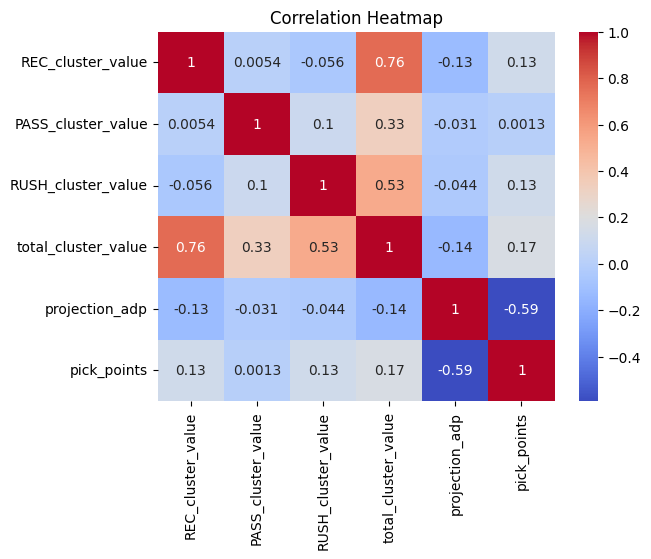

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the cluster heatmap
sns.heatmap(regular_21_22[['REC_cluster_value', 'PASS_cluster_value', 'RUSH_cluster_value', 'total_cluster_value', 'projection_adp', 'pick_points']].corr(method='spearman'),
               annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

**Regression**- To help understand exactly how much positive and negative total_cluster_value is worth in extra pick points we look to AI and apply a cutting edge methodology called regression 🤪

I compared both a standard linear regression and a Generalized Linear Model (GLM) and the GLM model produced far better results when looking at R values so this is the one I am including here.

I think it's probably due to pick points not being normally distributed and a GLM allows you to model the response's actual distribution, even if it is skewed or has heavy tails. While standard linear regression assumes that the response variable follows a normal distribution


 **TLDR**:

*   Both total_cluster_value and projection_adp are statistically significant.
*   By avoiding the less explosive players we can save 14 pick points on average. This is a pretty large increase especially when the mean pick points is only 84.
*   By targeting the more explosive players we can gain the same 14 pick points on average.



In [12]:
'''
Applying a GLM Model to help understand how much each move in total cluster value is worth.

Note: This requires a lot of processing power and can sometimes cause my
'''
import statsmodels.api as sm

X = regular_21_22[['total_cluster_value', 'projection_adp']]
y = regular_21_22['pick_points']

# Add a constant term to the independent variables to include the intercept term in the regression
X = sm.add_constant(X)

# Fit the generalized linear model
model = sm.GLM(y, X, family=sm.families.Gaussian()).fit()

# Print the summary of the GLM results
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            pick_points   No. Observations:              2796750
Model:                            GLM   Df Residuals:                  2796747
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          2712.5
Method:                          IRLS   Log-Likelihood:            -1.5023e+07
Date:                Fri, 28 Jul 2023   Deviance:                   7.5861e+09
Time:                        20:32:08   Pearson chi2:                 7.59e+09
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3964
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 141.0398    

**Pick Points and Total Cluster Value by Round**

Findings

1.   Rounds 1 and 2 look to be really efficient. No one cluster value type leads.
2.   After round 3 it's obvious the market is not pricing player upside correctly. You can see total value cluster 1 (Explosive Cluster) leads all the way through the rest of the draft. It's clear maximizing for explosive players gives you an edge.

Methodology

1.   Group the players by the pick number they were drafted and total cluster value they belong to.
2.   Calculate the average player pick points for each pick number and total cluster value
3.   Group the pick numbers into rounds and take the mean.


In [13]:
'''
We are creating a dataframe to see how total cluster value for a player leads to under or over performance when it comes to average pick points.

Steps
1.   Group the players by the pick number they were drafted and total cluster value they belong to.
2.   Calculate the average player pick points for each pick number and total cluster value
3.   Group the pick numbers into rounds and take the mean.
'''

pick_value_2022=pd.pivot_table(regular_2022_final[(regular_2022_final['total_cluster_value']<2) & (regular_2022_final['projection_adp']!=0)],
                             values='pick_points',
                             index='overall_pick_number',
                             columns='total_cluster_value',
                             aggfunc='mean')

pick_value_2021=pd.pivot_table(regular_2021_final[(regular_2021_final['total_cluster_value']<2) & (regular_2021_final['projection_adp']!=0)],
                             values='pick_points',
                             index='overall_pick_number',
                             columns='total_cluster_value',
                             aggfunc='mean')

pick_value_21_22=pd.concat([pick_value_2022, pick_value_2021])

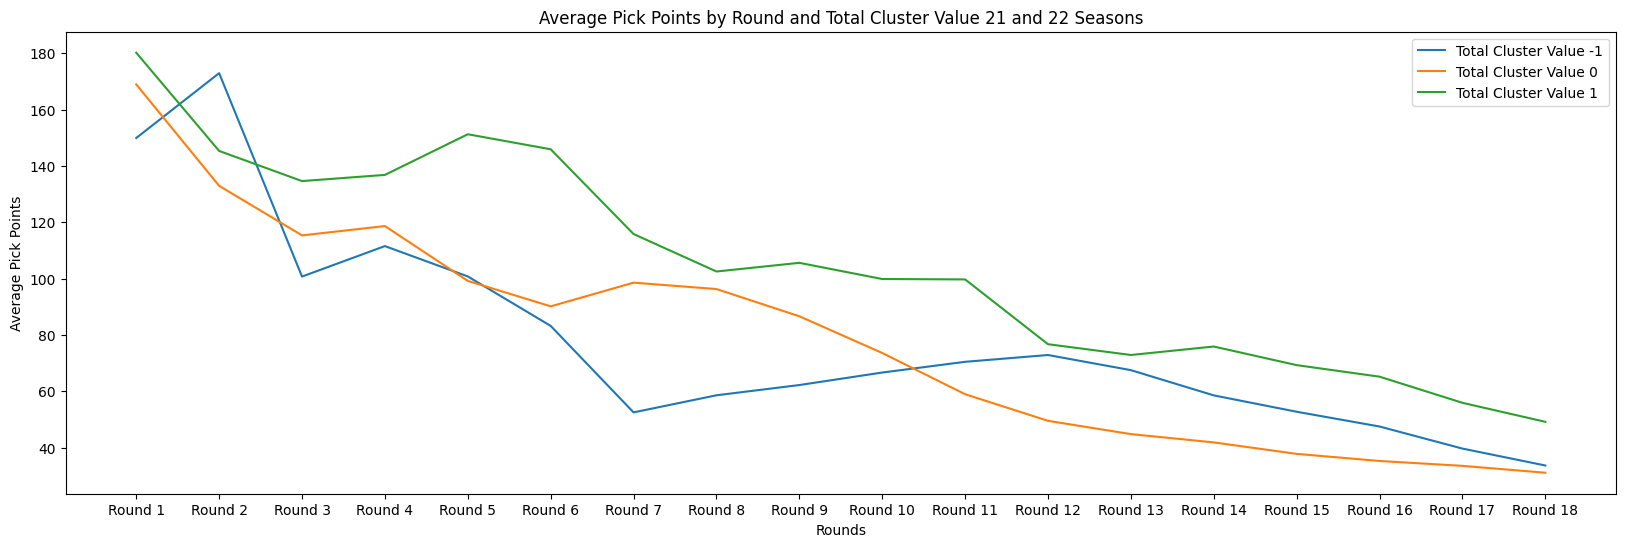

In [14]:
# Step 1: Create bins for rounds
bins = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216]
labels = ['Round {}'.format(i) for i in range(1, len(bins))]
pick_value_21_22['Round'] = pd.cut(pick_value_21_22.index.get_level_values(0), bins=bins, labels=labels)

# Step 2: Calculate the average pick points for each bin and total_cluster_value
pivot_avg_pick_points = pick_value_21_22.groupby('Round').mean()

# Step 3: Create a line plot for each total_cluster_value (-1, 0, 1)
plt.figure(figsize=(20, 6))
for value in [-1, 0, 1]:
    plt.plot(pivot_avg_pick_points.index, pivot_avg_pick_points[value], label='Total Cluster Value {}'.format(value))

# Set labels, title, and legend
plt.xlabel('Rounds')
plt.ylabel('Average Pick Points')
plt.title('Average Pick Points by Round and Total Cluster Value 21 and 22 Seasons')
plt.legend()

# Display the plot
plt.show()

### <u> Top 1% of Teams </u>

Findings:


1.   As the REC, RUSH, and total cluster values increase, the odds of achieving a top 1% outcome also increase.
2.   The PASS cluster value, as is consistent with our correlation results above, doesn't illustrate this same trend. In fact it's nearly the opposite. In order to find explosive quarterbacks we might have to take a different clustering approach or perhaphs variance between QBs could be very similar.
3.  The graph also appears to reflect the impact of macro roster construction. As we move to the far right in the REC and RUSH cluster values, the percentage chance actually decreases. However, the total cluster value graph continues to increase as its value increases. This observation indicates that loading up too much in a single positional category is detrimental. For more insight into optimal roster construction, the [ETR Manifesto](https://establishtherun.com/best-ball-mania-manifesto-a-guide-to-winning-big-on-underdog-fantasy/) provides comprehensive analysis.


Methodology:

1.   Calculate the total REC, RUSH, PASS, and total cluster value for each team
2.   Calculate the average percent of the time each cluster finishes in the top 1% of all teams for regular season scoring.

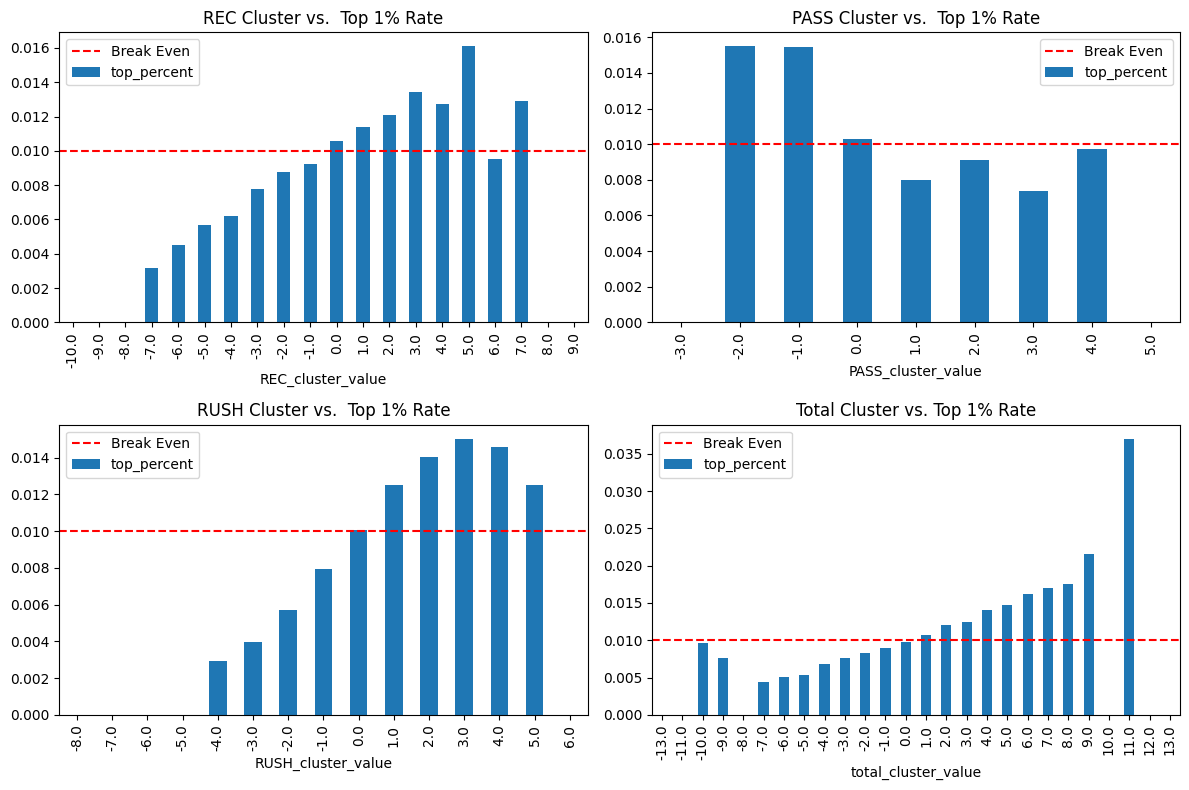

In [15]:
# Create pivot tables for the four bar charts
pivot_rec = pd.pivot_table(team_data_21_22, index='REC_cluster_value', values='top_percent', aggfunc='mean')
pivot_pass = pd.pivot_table(team_data_21_22, index='PASS_cluster_value', values='top_percent', aggfunc='mean')
pivot_rush = pd.pivot_table(team_data_21_22, index='RUSH_cluster_value', values='top_percent', aggfunc='mean')
pivot_total = pd.pivot_table(team_data_21_22, index='total_cluster_value', values='top_percent', aggfunc='mean')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot the first bar chart
pivot_rec.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('REC Cluster vs.  Top 1% Rate')
axes[0, 0].axhline(0.01, color='r', linestyle='dashed', label='Break Even')
axes[0, 0].legend()

# Plot the second bar chart
pivot_pass.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('PASS Cluster vs.  Top 1% Rate')
axes[0, 1].axhline(0.01, color='r', linestyle='dashed', label='Break Even')
axes[0, 1].legend()

# Plot the third bar chart
pivot_rush.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('RUSH Cluster vs.  Top 1% Rate')
axes[1, 0].axhline(0.01, color='r', linestyle='dashed', label='Break Even')
axes[1, 0].legend()

# Plot the fourth bar chart
pivot_total.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Total Cluster vs. Top 1% Rate')
axes[1, 1].axhline(0.01, color='r', linestyle='dashed', label='Break Even')
axes[1, 1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### <u> Playoff Advance Rates </u>

Findings:


1.   The findings are nearly identical to the top 1% teams. REC, RUSH, and total cluster value show a positive relationship between cluster value and percentage increase in playoff advance rates
2.   Once again the PASS cluster value seemed to buck the trend.

Methodology
1.   Calculate the total REC, RUSH, PASS, and total cluster value for each team
2.   Calculate the average percent of the time each cluster advances to the playoffs.




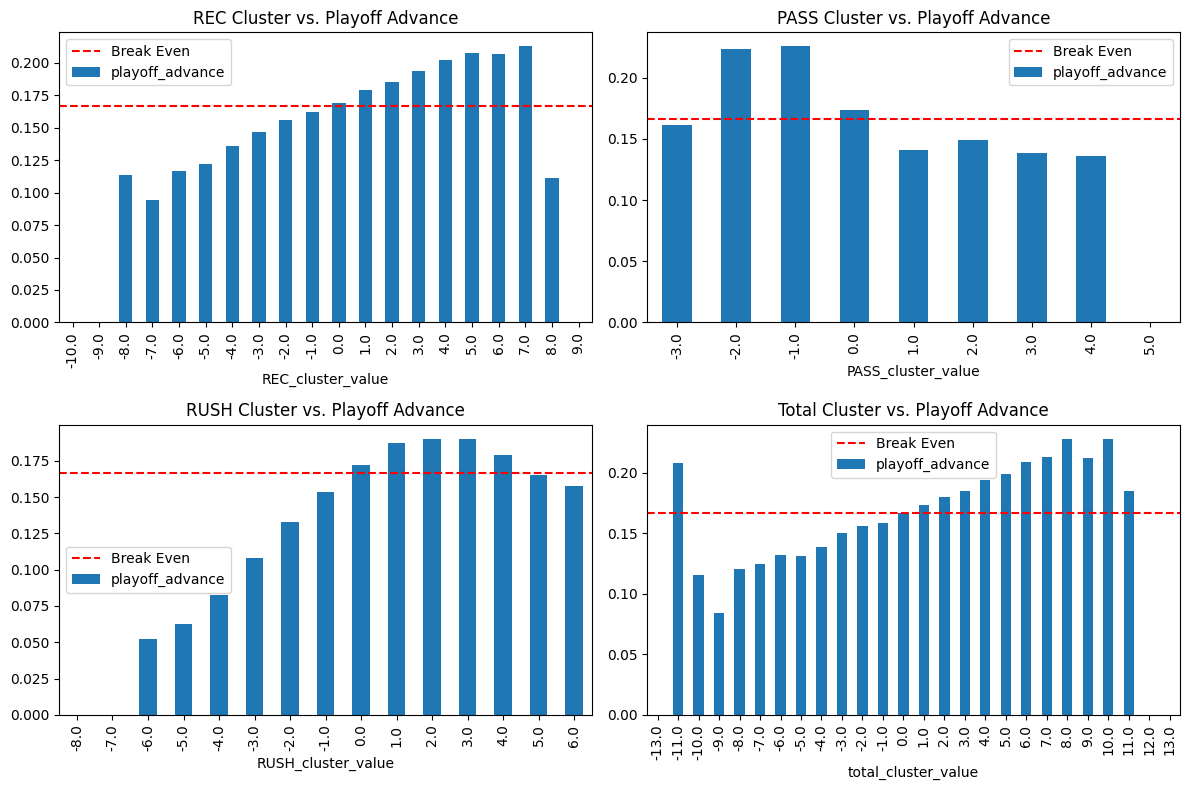

In [16]:
# Create pivot tables for the four bar charts
pivot_rec = pd.pivot_table(team_data_21_22, index='REC_cluster_value', values='playoff_advance', aggfunc='mean')
pivot_pass = pd.pivot_table(team_data_21_22, index='PASS_cluster_value', values='playoff_advance', aggfunc='mean')
pivot_rush = pd.pivot_table(team_data_21_22, index='RUSH_cluster_value', values='playoff_advance', aggfunc='mean')
pivot_total = pd.pivot_table(team_data_21_22, index='total_cluster_value', values='playoff_advance', aggfunc='mean')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot the first bar chart
pivot_rec.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('REC Cluster vs. Playoff Advance')
axes[0, 0].axhline(0.16666666, color='r', linestyle='dashed', label='Break Even')
axes[0, 0].legend()

# Plot the second bar chart
pivot_pass.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('PASS Cluster vs. Playoff Advance')
axes[0, 1].axhline(0.16666666, color='r', linestyle='dashed', label='Break Even')
axes[0, 1].legend()

# Plot the third bar chart
pivot_rush.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('RUSH Cluster vs. Playoff Advance')
axes[1, 0].axhline(0.16666666, color='r', linestyle='dashed', label='Break Even')
axes[1, 0].legend()

# Plot the fourth bar chart
pivot_total.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Total Cluster vs. Playoff Advance')
axes[1, 1].axhline(0.16666666, color='r', linestyle='dashed', label='Break Even')
axes[1, 1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# **Conclusion**
Looking at this data an obvious new wrinkle to drafting emerges, maximizing explosive players at RB/WR/TE. By applying a simple three point cluster strategy of -1, 0, and 1 it gives any drafter the ability to easily see who to target and avoid. Much like a card counter, who is looking to identify the blackjack shoe full of 10s, we are looking to stack a team full of explosive players to create an edge. This player level draft strategy can be easily overlaid on top of what the community has already found to be positive advantages when it comes to stacking, roster construction, and ADP value.

I don't think it's some crazy revelation that variance helps in Best Ball. Probably no one would argue this point. I think what's staggering is how much we still undervalue it. I have a couple of theories as to why. First off ADP is driven by rankings of the content sites. All of the content sites which produce Best Ball Rankings also produce season long rankings. I think the season long rankings anchor the Best Ball rankings even though the games are very different. In Best Ball you can throw away more then half of your player scores each week! I built a toy best ball simulation below so you can get a rough idea of just how valuable that can be.

The second, which is maybe a cop-out, is utilizing variance in player rankings is incredibly difficult. Really to do this well you need a sophisticated simulation and I don't think people are putting this level of effort into their Best Ball rankings. Which is probably why a simple clustering strategy has value right now.

### **Toy Best Ball Simulation**

Shows how valuable an extra boost in mean points or standard deviation of points is when it comes to total points. Both boost values are added to team 2.

In [18]:
'''
A toy Best Ball simulation with fake player means and variances which shows how valuable an extra boost in mean points or standard deviation of points is
when it comes to total points.

Both boost values are added to team 2
'''

import numpy as np
mean_boost=0
std_boost=1

# Set the random seed for reproducibility
np.random.seed(42)

# Mean and Standard Deviation for Team 1
mean_team1 = np.array([23.75, 18.13542, 15.72917, 14.125, 13.65625, 13.27083, 12.66667, 10.80208, 9.729167, 9.0625,
                       8.145833, 7.322917, 6.677083, 6.552083, 6.28125, 5.645833, 4.708333, 3.822917])
std_dev_team1 = np.array([9.5, 7.254167, 6.291667, 5.65, 5.4625, 5.308333, 5.066667, 4.320833, 3.891667, 3.625,
                         3.258333, 2.929167, 2.670833, 2.620833, 2.5125, 2.258333, 1.883333, 1.529167])

# Number of simulations and weeks
num_simulations = 1000
num_weeks = 16

# Initialize lists to store total scores for each team and the winning team for each simulation
team1_scores = []
team2_scores = []
winning_teams = []

# Run the simulations
for _ in range(num_simulations):
    # Initialize total scores for each team
    total_score_team1 = 0
    total_score_team2 = 0

    for week in range(num_weeks):
        # Draw samples for each player in Team 1 and Team 2
        team1_samples = np.random.normal(loc=mean_team1, scale=std_dev_team1)
        team2_samples = np.random.normal(loc=mean_team1+mean_boost, scale=std_dev_team1 + std_boost)

        # Find the highest 8 scores for each team and add to the total score for the week
        total_score_team1 += np.sum(np.sort(team1_samples)[-8:])
        total_score_team2 += np.sum(np.sort(team2_samples)[-8:])

        # total_score_team1 += np.sum(team1_samples)
        # total_score_team2 += np.sum(team2_samples)

    # Store the total scores for each team
    team1_scores.append(total_score_team1)
    team2_scores.append(total_score_team2)

    # Determine the winning team for this simulation
    winning_teams.append(1 if total_score_team1 > total_score_team2 else 2)

# Calculate the average points and win rate for each team
average_points_team1 = np.mean(team1_scores)
average_points_team2 = np.mean(team2_scores)
win_rate_team1 = sum(1 for winner in winning_teams if winner == 1) / num_simulations
win_rate_team2 = sum(1 for winner in winning_teams if winner == 2) / num_simulations

# Print the results
print("Mean Boost for Team 2:", mean_boost)
print("Std Dev Boost for Team 2:", std_boost)
print("Average points for Team 1:", average_points_team1)
print("Average points for Team 2:", average_points_team2)
print("Win rate for Team 1:", win_rate_team1)
print("Win rate for Team 2:", win_rate_team2)


Mean Boost for Team 2: 0
Std Dev Boost for Team 2: 1
Average points for Team 1: 2090.529500808639
Average points for Team 2: 2164.385435730194
Win rate for Team 1: 0.217
Win rate for Team 2: 0.783
